# Sales prediction with XGBoost, optimized with Optuna

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import optuna
import sklearn.ensemble
import sklearn.svm

In [2]:
df = pd.read_csv("Stores.csv")

In [3]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Store ID,896.0,448.500000,258.797218,1.0,224.75,448.5,672.25,896.0
Store_Area,896.0,1485.409598,250.237011,775.0,1316.75,1477.0,1653.50,2229.0
Items_Available,896.0,1782.035714,299.872053,932.0,1575.50,1773.5,1982.75,2667.0
Daily_Customer_Count,896.0,786.350446,265.389281,10.0,600.00,780.0,970.00,1560.0
Store_Sales,896.0,59351.305804,17190.741895,14920.0,46530.00,58605.0,71872.50,116320.0


## Exploratory analysis

### Get data distribution and visualize skew

In [4]:
def answer_distribution_and_skew(variable: str, fignum: int = 0):
    '''
    Use this function to analyze a variable's distribution and visualize its skew.
    Specify the number of figure for calling this many times.
    I don't implement this with subplot in case I only want to see one variable.
    '''
    plt.figure(fignum)
    sns.displot(df[variable])
    plt.axvline(x=np.mean(df[variable]), c='red', ls='--', label='mean')
    plt.axvline(x=np.percentile(df[variable],25),c='green', ls='--', label = '25th percentile:Q1')
    plt.axvline(x=np.percentile(df[variable],75),c='orange', ls='--',label = '75th percentile:Q3' )
    plt.legend()
    return None

<Figure size 432x288 with 0 Axes>

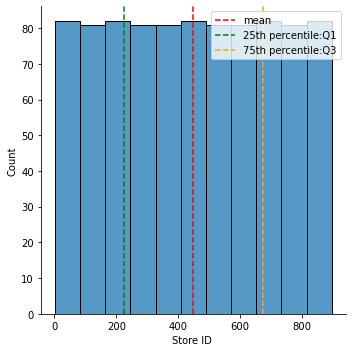

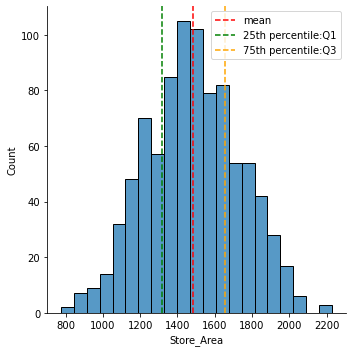

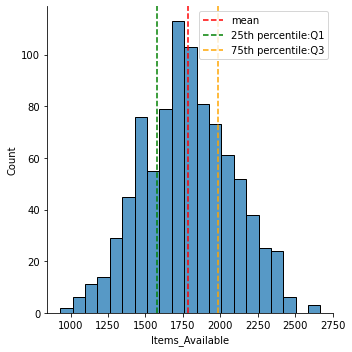

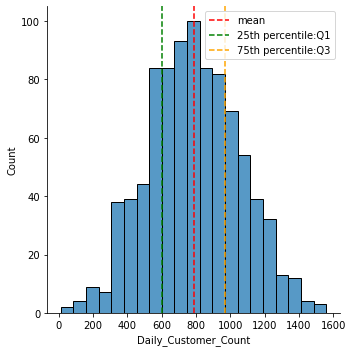

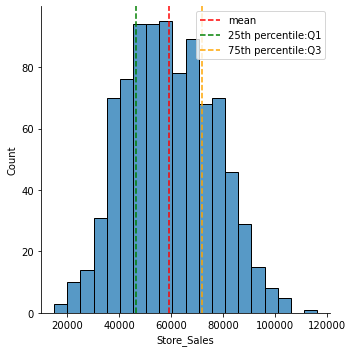

In [5]:
i = 0
for col in df.columns.values.tolist():
    answer_distribution_and_skew(col, i)
    i += 1

### Get bi variable relationships with trendlines

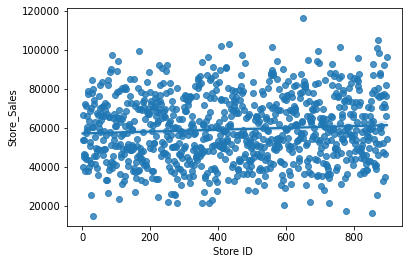

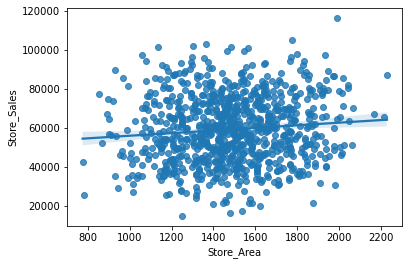

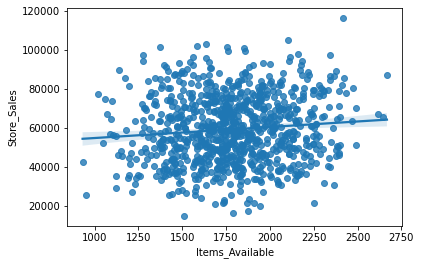

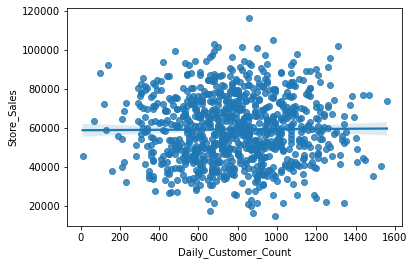

In [6]:
def answer_sales_per_variable(variable: str, fignum: int = 0, y:str = "Store_Sales", df: pd.DataFrame = df):
    plt.figure(fignum)
    sns.regplot(x = variable, y = y, data = df)

i = 0
for col in [x for x in df.columns.values.tolist() if x != "Store_Sales"]:
    answer_sales_per_variable(col, i)
    i += 1

### There are no easily spotted relationships within the data apart from the physically correlated features of Store Area and Items Available

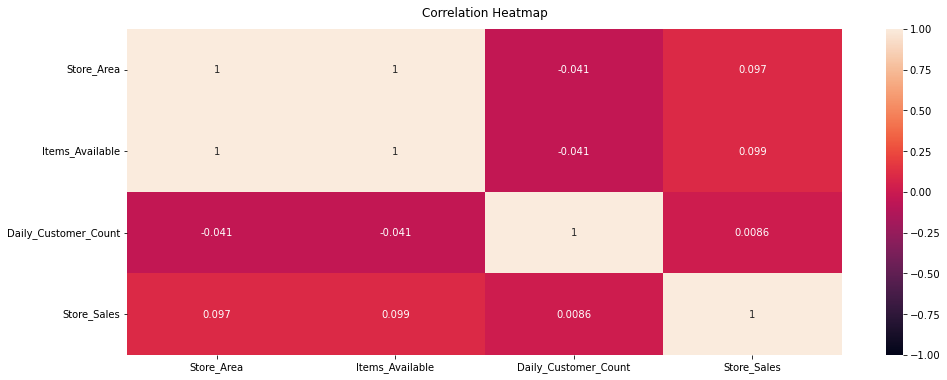

In [7]:
# Below I exclude Store ID because it has no causal correlations with other variables
try:
    df.rename(columns = {'Store ID ':'Store ID'}, inplace = True)
except:
    pass
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df.drop("Store ID", axis=1).corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

Text(0.5, 1.0, 'Triangle Correlation Heatmap')

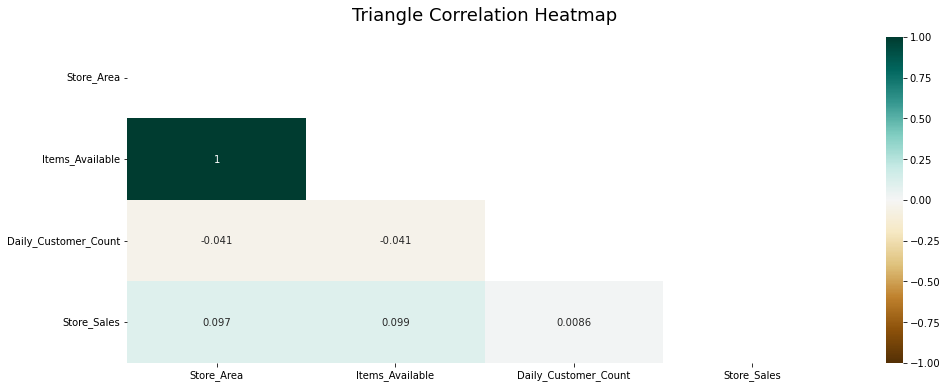

In [8]:
# Another way of visualizing the correlations: Triangular heatmap that only shows each correlation of interest once
plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(df.drop("Store ID", axis=1).corr(), dtype=bool))
heatmap = sns.heatmap(df.drop("Store ID", axis=1).corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16)

## Feature engineering: Encode variables for easier training

In [9]:
def target_feature_mapping(target: str, df: pd.DataFrame):
    '''
    Map the target feature to a categorical column based on quantiles (encoded by integer values)
    '''
    quantile_025 = df[target].quantile(0.25)
    quantile_050 = df[target].quantile(0.5)
    quantile_075 = df[target].quantile(0.75)

    def mapper(value):
        '''
        Map sales by quantile to a "volume of total sales" category encoding
        '''
        if value < quantile_025:
            return 0 # Low
        elif quantile_050 > value >= quantile_025:
            return 1 # Medium low
        elif quantile_075 > value >= quantile_050:
            return 2 # Medium high
        elif value >= quantile_075:
            return 3 # High
        else:
            return np.nan

    df["Sales_Volume"] = df[target].apply(mapper)
    return df

### Encode target feature and add features for expressing spatial relationships for item placement and daily clients per venue

In [10]:
def normalize_feature(feature: pd.Series):
    mean = feature.mean()
    stdev = feature.std()
    return (feature - mean) / stdev

In [11]:
df = target_feature_mapping("Store_Sales", df)

In [12]:
def get_sales_volume_name(value: int):
    '''
    Function for temporarily replacing the encoded target feature to a human readable form
    '''
    if value == 0:
        return "Low"
    elif value == 1:
        return "Medium low"
    elif value == 2:
        return "Medium high"
    elif value == 3:
        return "High"
    else:
        return np.nan

In [13]:
def grouped_features(column: str, replace_encoding: bool = True):
    '''
    Use a temporary grouped dataframe to appreciate that the encoding performed makes sense
    '''
    all_cols = [x for x in df.columns.values.tolist() if x != "Store ID" and x != column and x != "Store_Sales"]
    groups = df.sort_values([column],ascending=True).groupby(column)
    sums_vals = groups[all_cols].sum().add_suffix('_sum')
    avgs_vals = groups[all_cols].mean().add_suffix('_avg')
    groups = pd.concat([sums_vals, avgs_vals], axis=1)
    if replace_encoding and column == "Sales_Volume":
        groups = groups.reset_index()
        description = column + "_Categories"
        groups[description] = groups[column].apply(get_sales_volume_name)
        groups = groups[[description] + [c for c in groups if c != description]]
    return groups

In [14]:
grouped_test_df = grouped_features("Sales_Volume")

In [15]:
grouped_test_df

,Sales_Volume_Categories,Sales_Volume,Store_Area_sum,Items_Available_sum,Daily_Customer_Count_sum,Store_Area_avg,Items_Available_avg,Daily_Customer_Count_avg
0,Low,0,322538,386781,174470,1439.901786,1726.700893,778.883929
1,Medium low,1,333018,399553,178740,1486.687500,1783.718750,797.946429
2,Medium high,2,338953,406727,176180,1513.183036,1815.745536,786.517857
3,High,3,336418,403643,175180,1501.866071,1801.977679,782.053571


### Examine new correlations among the features in the grouped dataframe we just made

Text(0.5, 1.0, 'Triangle Correlation Heatmap')

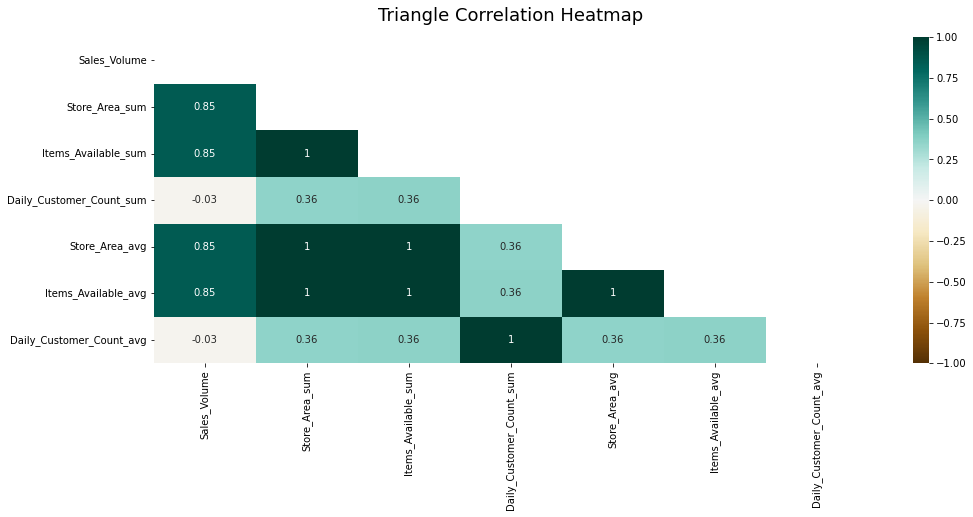

In [16]:
plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(grouped_test_df.corr(), dtype=bool))
heatmap = sns.heatmap(grouped_test_df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16)

### Let's fit a regression line again. Now correlations are visible!

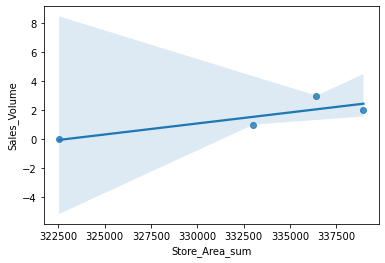

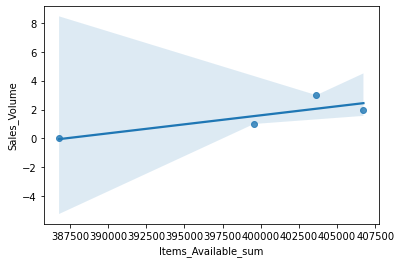

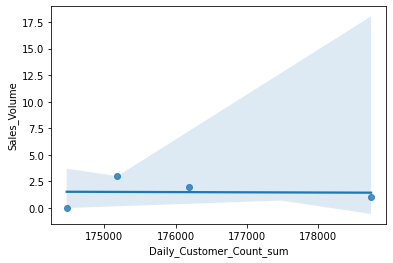

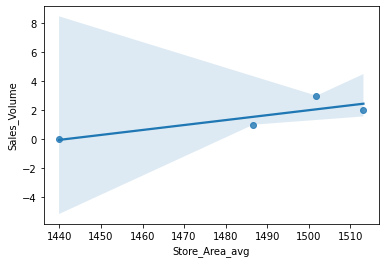

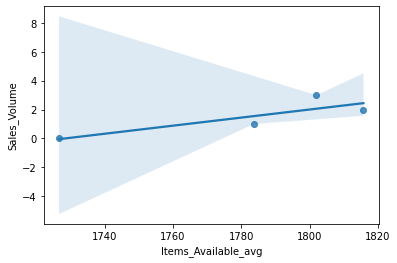

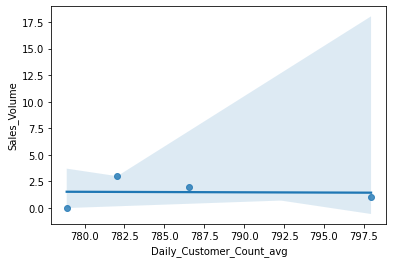

In [17]:
i = 0
for col in [x for x in grouped_test_df.columns.values.tolist() if x != "Store_Sales" and x != "Sales_Volume" and x != "Sales_Volume_Categories"]:
    answer_sales_per_variable(col, i, "Sales_Volume", grouped_test_df)
    i += 1

## Prediction of Sales Volume with XGBoost

### Search for best eps parameter to use in DBSCAN clustering for data augmentation

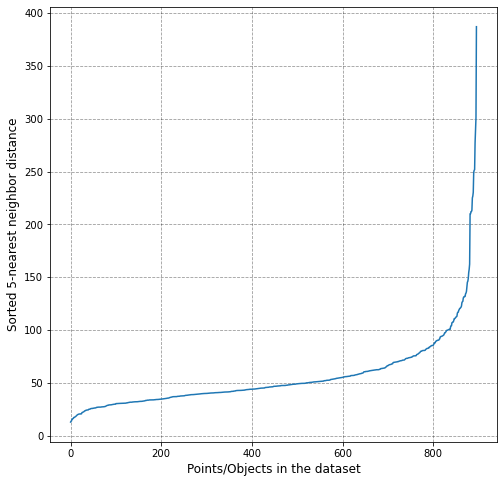

In [18]:
def get_kdist_plot(X=None, k=None, radius_nbrs=1.0):
    '''
    Estimate optimal eps parameter for DBSCAN based on probing k distances and plotting the results.
    Original here: https://bit.ly/38BiKCX
    '''
    nbrs = NearestNeighbors(n_neighbors=k, radius=radius_nbrs).fit(X)

    # For each point, compute distances to its k-nearest neighbors
    distances, indices = nbrs.kneighbors(X) 

    distances = np.sort(distances, axis=0)
    distances = distances[:, k-1]

    # Plot the sorted K-nearest neighbor distance for each point in the dataset
    plt.figure(figsize=(8,8))
    plt.plot(distances)
    plt.xlabel('Points/Objects in the dataset', fontsize=12)
    plt.ylabel('Sorted {}-nearest neighbor distance'.format(k), fontsize=12)
    plt.grid(True, linestyle="--", color='black', alpha=0.4)
    plt.show()
    plt.close()

# Estimate optimal value for eps.
target_col = "Sales_Volume"
if "Sales" in target_col:
    to_drop = ["Sales_Volume", "Store_Sales", "Store ID"]
else:
    to_drop = [target_col, "Store ID"]
X = df.drop(to_drop, axis=1)
y = df[target_col]
k = 2 * X.shape[-1] - 1 # k=2*{dim(dataset)} - 1
get_kdist_plot(X=X, k=k)

In [19]:
# Compute test DBSCAN
db = DBSCAN(eps=100, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
unique, counts = np.unique(labels, return_counts=True)
print("Labels and their frequencies: {}".format(dict(zip(unique, counts))))

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y, labels))
print("Completeness: %0.3f" % metrics.completeness_score(y, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(y, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(y, labels))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(y, labels)
)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))

Labels and their frequencies: {-1: 106, 0: 778, 1: 12}
Estimated number of clusters: 2
Estimated number of noise points: 106
Homogeneity: 0.005
Completeness: 0.017
V-measure: 0.008
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.004
Silhouette Coefficient: 0.205


### Optuna hyperparameter tuning setup

In [20]:
def prepare_train_test(df: pd.DataFrame, target_col: str):
    if "Sales" in target_col:
        to_drop = ["Sales_Volume", "Store_Sales", "Store ID"]
    else:
        to_drop = [target_col, "Store ID"]
    data = df.drop(to_drop, axis=1)
    target = df[target_col]
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.25, random_state=42)
    
    # Generate relationship - based features for train and test split. That way the training split has no proxy of the contents of the test set.
    train_x.loc[:, "Items_to_Store_Area"] = normalize_feature(train_x["Items_Available"])/normalize_feature(train_x["Store_Area"])
    train_x.loc[:, "Items_to_Daily_Customers"] = normalize_feature(train_x["Items_Available"])/normalize_feature(train_x["Daily_Customer_Count"])
    test_x.loc[:, "Items_to_Store_Area"] = normalize_feature(test_x["Items_Available"])/normalize_feature(test_x["Store_Area"])
    test_x.loc[:, "Items_to_Daily_Customers"] = normalize_feature(test_x["Items_Available"])/normalize_feature(test_x["Daily_Customer_Count"])
    
    # Generate clustering for data augmentation for train and test set. Again, clustering should be done 
    # separately to avoid giving proxy data of the test set while training.
    # Because of the little amount of features this may not augment the dataset a great deal, but it's worth testing.
    train_x.loc[:, "Cluster"] = DBSCAN(eps=100, min_samples=10).fit_predict(train_x)
    test_x.loc[:, "Cluster"] = DBSCAN(eps=100, min_samples=10).fit_predict(test_x)
    return train_x, test_x, train_y, test_y

In [21]:
# Objective function adapted from Optuna docs. There's not a compelling reason not to use this recipe.

def objective(trial, df: pd.DataFrame = df, target_col: str = "Sales_Volume"):
    # Drop columns that shouldn't be used to train, like the non encoded sales column and the Store ID that has no causal relationship
    train_x, test_x, train_y, test_y = prepare_train_test(df, target_col)
    
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dtest = xgb.DMatrix(test_x, label=test_y)

    param = {
        "silent": 0, # completely silent, change to 1 if you want to see the warnings
        "objective": "multi:softmax",
        "num_class": 4,
        "eval_metric": "auc",
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
        "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
    }

    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 9)
        param["eta"] = trial.suggest_loguniform("eta", 1e-8, 1.0)
        param["gamma"] = trial.suggest_loguniform("gamma", 1e-8, 1.0)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_loguniform("rate_drop", 1e-8, 1.0)
        param["skip_drop"] = trial.suggest_loguniform("skip_drop", 1e-8, 1.0)

    # Add a callback for pruning.
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-auc")
    bst = xgb.train(param, dtrain, evals=[(dtest, "validation")], callbacks=[pruning_callback])
    trial.set_user_attr(key="best_booster", value=bst)
    preds = bst.predict(dtest)
    pred_labels = np.rint(preds)
    accuracy = metrics.accuracy_score(test_y, pred_labels)
    return accuracy

In [22]:
def callback(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key="best_booster", value=trial.user_attrs["best_booster"])

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600, callbacks=[callback])

In [24]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
best_model=study.user_attrs["best_booster"]
# Let's save the best model for inference
best_model.save_model('./model.bst')

Number of finished trials:  100
Best trial:
  Value: 0.35714285714285715
  Params: 
    booster: gbtree
    lambda: 2.208874857560301e-07
    alpha: 3.4602423613433205e-08
    max_depth: 3
    eta: 0.004505436531843194
    gamma: 0.005643984992471073
    grow_policy: depthwise


### Visualization of feature importances

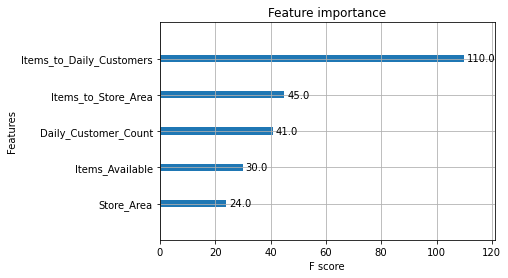

In [25]:
xgb.plot_importance(best_model)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

## How much is won by using XGBoost over purely random choice of Sales Volume?

### Even with small datasets XGBoost is a solid model of choice.
### This result could be better if the dataset was richer in features. 

In [26]:
# The probability of drawing any single value among the four possible categories is 1/4, or 0.25. 
# That's why the expected random accuracy is 25%.
xgboost_value = trial.value
compare_1 = (xgboost_value - 0.25)*100
print("{:.2f} % of accuracy".format(compare_1))

10.71 % of accuracy


## Compare XGBoost to another baseline: Sklearn's classifiers

In [27]:
def prepare_train_test_sklearn(df: pd.DataFrame, target_col: str):
    if "Sales" in target_col:
        to_drop = ["Sales_Volume", "Store_Sales", "Store ID"]
    else:
        to_drop = [target_col, "Store ID"]
    train_x = df.drop(to_drop, axis=1)
    train_y = df[target_col]
    
    train_x.loc[:, "Items_to_Store_Area"] = normalize_feature(train_x["Items_Available"])/normalize_feature(train_x["Store_Area"])
    train_x.loc[:, "Items_to_Daily_Customers"] = normalize_feature(train_x["Items_Available"])/normalize_feature(train_x["Daily_Customer_Count"])

    train_x.loc[:, "Cluster"] = DBSCAN(eps=100, min_samples=10).fit_predict(train_x)
    return train_x, train_y

In [28]:
# FYI: Objective functions can take additional arguments
# (https://optuna.readthedocs.io/en/stable/faq.html#objective-func-additional-args).
def objective(trial, df: pd.DataFrame = df, target_col: str = "Sales_Volume"):
    x, y = prepare_train_test_sklearn(df, target_col)

    classifier_name = trial.suggest_categorical("classifier", ["SVC", "RandomForest"])
    if classifier_name == "SVC":
        svc_c = trial.suggest_float("svc_c", 1e-10, 1e10, log=True)
        classifier_obj = sklearn.svm.SVC(C=svc_c, gamma="auto")
    else:
        rf_max_depth = trial.suggest_int("rf_max_depth", 2, 32, log=True)
        classifier_obj = sklearn.ensemble.RandomForestClassifier(
            max_depth=rf_max_depth, n_estimators=10
        )

    score = cross_val_score(classifier_obj, x, y, n_jobs=-1, cv=3)
    accuracy = score.mean()
    trial.set_user_attr(key="best_sklearn", value=classifier_obj)
    return accuracy


In [29]:
def callback(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key="best_sklearn", value=trial.user_attrs["best_sklearn"])

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, callbacks=[callback])

In [31]:
print(study.best_trial)

FrozenTrial(number=61, values=[0.28903578670138347], datetime_start=datetime.datetime(2022, 4, 30, 19, 38, 37, 853127), datetime_complete=datetime.datetime(2022, 4, 30, 19, 38, 37, 882706), params={'classifier': 'RandomForest', 'rf_max_depth': 2}, distributions={'classifier': CategoricalDistribution(choices=('SVC', 'RandomForest')), 'rf_max_depth': IntLogUniformDistribution(high=32, low=2, step=1)}, user_attrs={'best_sklearn': RandomForestClassifier(max_depth=2, n_estimators=10)}, system_attrs={}, intermediate_values={}, trial_id=61, state=TrialState.COMPLETE, value=None)


### How much better is XGBoost compared to the model chosen with Sklearn? 

In [32]:
compare_2 = (xgboost_value - study.best_trial.value)*100
print("{:.2f} % of accuracy".format(compare_2))

6.81 % of accuracy


## Conclusion: Is XGBoost better than random choice and an Sklearn Random Forest?

In [33]:
print("Answer: {}, by {:.2f} % accuracy on average".format("Yes" if compare_1 > 0 and compare_2 > 0 else "No", 0.5*(compare_1 + compare_2)))

Answer: Yes, by 8.76 % accuracy on average
